In [2]:
from synoptic.services import stations_timeseries
import matplotlib.pyplot as plt
import matplotlib as mpl
from pyodide.http import open_url

import itertools
import requests
import re
import json
import numpy as np
import pandas as pd
from matplotlib.patches import Polygon

# Change default date formatter
plt.rcParams["date.autoformatter.day"] = "%b %d\n%H:%M"
plt.rcParams["date.autoformatter.hour"] = "%b %d\n%H:%M"


/home/blaylock/GITHUB/SynopticPy/synoptic/accessors.py:28: UserWarning: map making not available without Brian's cartopy_tools
  warnings.warn("map making not available without Brian's cartopy_tools")


In [11]:
import pandas as pd


class Smoother:
    """An object to hold smoothing parameters and do smoothing.

    Usage
    -----
    Presently, you must explicitly set the smoothing params after instantiation.
    >>> smooth = Smoother()
    >>> smooth.method = "rolling"
    >>> smooth.interval = "3H"
    >>> smooth.stat = "mean"
    >>> df2 = smooth.smooth_dataframe(df)
    """

    def __init__(self):
        self._method = None
        self._interval = None
        self._interval_str = None
        self._stat = None

    @property
    def method(self):
        return self._method

    @method.setter
    def method(self, value):
        methods = {"rolling", "resample", None}
        if isinstance(value, str):
            value = value.lower()
        if value == "none":
            value = None
            self._interval = None
            self._interval_str = None
            self._stat = None
        if value in methods:
            self._method = value
        else:
            print("⛔ ERROR: Smoother method must be one of the following:")
            print(f"    └ {methods}")
            raise ValueError(
                f"Invalid value for 'method'. Allowed values are one of {methods}."
            )

    @property
    def interval(self):
        return self._interval

    @interval.setter
    def interval(self, value):
        self.interval_str = value
        try:
            value = pd.to_timedelta(value)
        except (ValueError, TypeError):
            print(f"⛔ ERROR: Smoother interval {value} could not be parsed by Pandas.")
            print(f"    └ Input a timedelta string like '12min', '6H', '3D' instead.")
            raise ValueError(
                "Invalid value for 'interval'. Must be a Pandas-parsable timedelta."
            )
        self._interval = value

    @property
    def stat(self):
        return self._stat

    @stat.setter
    def stat(self, value):
        stats = {"mean", "max", "min", "median", "std", "var", "count", "spread"}
        if value == "none":
            value = None
        elif value not in stats:
            print(
                f"⚠️ WARNING: Smoother stat {value} is not in the list of expected values."
            )
            print(f"    └ {stats}")
        self._stat = value

    def __repr__(self) -> str:
        return f"Smoother: {self.method=} {self.interval=} {self._interval_str=} {self.stat=}"

    @property
    def label(self):
        return f"{self.interval_str} {self.method.title()} {self.stat.upper()}"

    def smooth_dataframe(self, df):
        """Smooth a Pandas Dataframe according to the smoothing parameters. Index must be a datetime."""
        preserve_attrs = df.attrs
        if self.method is None:
            print(f"⚠️ WARNING: No smoothing performed. {self.method=}.")
        elif self.stat.lower() == "spread":
            # "spread" is a special case
            if self.method == "resample":
                df = df.resample(self.interval).agg(["max", "min", "median", "mean"])
            elif self.method == "rolling":
                df = df.rolling(self.interval).agg(["max", "min", "median", "mean"])
        else:
            if self.method == "rolling":
                df = getattr(df.rolling(self.interval), self.stat)()
            elif self.method == "resample":
                df = getattr(df.resample(self.interval), self.stat)()
        df.attrs = preserve_attrs
        return df

    """An object to hold smoothing parameters and do smoothing.

    Usage
    -----
    Presently, you must explicitly set the smoothing params after instantiation.
    >>> smooth = Smoother()
    >>> smooth.method = "rolling"
    >>> smooth.interval = "3H"
    >>> smooth.stat = "mean"
    >>> df2 = smooth.smooth_dataframe(df)
    """

    def __init__(self):
        self._method = None
        self._interval = None
        self._interval_str = None
        self._stat = None

    @property
    def method(self):
        return self._method

    @method.setter
    def method(self, value):
        methods = {"rolling", "resample", None}
        if isinstance(value, str):
            value = value.lower()
        if value == "none":
            value = None
        if value in methods:
            self._method = value
        else:
            print("⛔ ERROR: Smoother method must be one of the following:")
            print(f"    └ {methods}")
            raise ValueError(
                f"Invalid value for 'method'. Allowed values are one of {methods}."
            )

    @property
    def interval(self):
        return self._interval

    @interval.setter
    def interval(self, value):
        self._interval_str = value
        try:
            value = pd.to_timedelta(value)
        except (ValueError, TypeError):
            print(f"⛔ ERROR: Smoother interval {value} could not be parsed by Pandas.")
            print(f"    └ Input a timedelta string like '12min', '6H', '3D' instead.")
            raise ValueError(
                "Invalid value for 'interval'. Must be a Pandas-parsable timedelta."
            )
        self._interval = value

    @property
    def stat(self):
        return self._stat

    @stat.setter
    def stat(self, value):
        stats = {"mean", "max", "min", "median", "std", "var", "count", "spread"}
        if value not in stats:
            print(
                f"⚠️ WARNING: Smoother stat {value} is not in the list of expected values."
            )
            print(f"    └ {stats}")
        self._stat = value

    def __repr__(self) -> str:
        return f"Smoother: {self.method=} {self.interval=} {self._interval_str=} {self.stat=}"

    @property
    def label(self):
        return f"{self._interval_str} {self.method} {self.stat.upper()}"

    def smooth_dataframe(self, df):
        """Smooth a Pandas Dataframe according to the smoothing parameters. Index must be a datetime."""
        if self.method is None:
            print(f"⚠️ WARNING: No smoothing performed. {self.method=}.")
        elif self.stat.lower() == "spread":
            # "spread" is a special case
            if self.method == "resample":
                df = df.resample(self.interval).agg(["max", "min", "median", "mean"])
            elif self.method == "rolling":
                df = df.rolling(self.interval).agg(["max", "min", "median", "mean"])
        else:
            if self.method == "rolling":
                df = getattr(df.rolling(self.interval), self.stat)()
            elif self.method == "resample":
                df = getattr(df.resample(self.interval), self.stat)()

        return df

In [24]:
smooth = Smoother()
smooth.method = "resample"
smooth.interval = "6H"
smooth.stat = "spread"

print(smooth)

smooth.smooth_dataframe(Z["UKBKB"])


Smoother: self.method='resample' self.interval=Timedelta('0 days 06:00:00') self._interval_str='6H' self.stat='spread'


air_temp_set_1                            
                                     max     min   median       mean
date_time                                                           
2023-06-15 06:00:00+00:00         15.000  12.778  13.3330  13.671304
2023-06-15 12:00:00+00:00         16.111  12.222  13.3330  14.141364
2023-06-15 18:00:00+00:00         21.667  11.111  18.3330  17.314667
2023-06-16 00:00:00+00:00         22.222  12.778  17.5000  17.222250
2023-06-16 06:00:00+00:00         12.778   9.444  11.1110  11.088042
2023-06-16 12:00:00+00:00         21.111   9.444  14.7220  14.675792
2023-06-16 18:00:00+00:00         25.556  21.667  24.1665  23.842542
2023-06-17 00:00:00+00:00         25.556  13.889  20.2780  20.138917
2023-06-17 06:00:00+00:00         13.889  13.889  13.8890  13.889000

In [27]:
a = smooth.smooth_dataframe(Z["UKBKB"])
a["air_temp_set_1"]["median"]

date_time
2023-06-15 06:00:00+00:00    13.3330
2023-06-15 12:00:00+00:00    13.3330
2023-06-15 18:00:00+00:00    18.3330
2023-06-16 00:00:00+00:00    17.5000
2023-06-16 06:00:00+00:00    11.1110
2023-06-16 12:00:00+00:00    14.7220
2023-06-16 18:00:00+00:00    24.1665
2023-06-17 00:00:00+00:00    20.2780
2023-06-17 06:00:00+00:00    13.8890
Freq: 6H, Name: median, dtype: float64

In [5]:
ZZ = stations_timeseries(
    stid="NAA,UKBKB,WBB,KMRY",
    recent="48H",
    vars="air_temp",
    rename_set_1=False,
)

Z = {}
for i in ZZ:
    Z[i.attrs["STID"]] = i

Z["WBB"].head()


Checking for data recent=2880 minutes.

 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=NAA,UKBKB,WBB,KMRY&recent=2880&vars=air_temp&token=🙈HIDDEN

Returned [4] stations. ['WBB', 'KMRY', 'UKBKB', 'NAA']


,air_temp_set_1
date_time,
2023-06-15 06:07:00+00:00,16.078
2023-06-15 06:08:00+00:00,16.078
2023-06-15 06:09:00+00:00,16.050
2023-06-15 06:10:00+00:00,16.028
2023-06-15 06:11:00+00:00,16.000


In [24]:
Z["WBB"].attrs.get("UNITS")

{'position': 'm',
 'dew_point_temperature': 'Celsius',
 'elevation': 'ft',
 'air_temp': 'Celsius'}

In [55]:
Z["NAA"].filter(regex="set_1")


,air_temp_set_1
date_time,
2023-06-12 04:35:00+00:00,18.211
2023-06-12 04:40:00+00:00,18.478
2023-06-12 04:45:00+00:00,18.528
2023-06-12 04:50:00+00:00,18.450
2023-06-12 04:55:00+00:00,18.411
...,...
2023-06-14 04:10:00+00:00,20.278
2023-06-14 04:15:00+00:00,19.961
2023-06-14 04:20:00+00:00,19.650


In [18]:
def plot_standard(
    df,
    only_plot_set_1=True,
    *,
    ax=None,
):
    if ax is None:
        ax = plt.gca()

    if only_plot_set_1:
        df = df.filter(regex="set_1")

    for column in sorted(df.columns):
        variable = re.sub(r"_set_\d+d?", "", column)
        units = df.attrs.get("UNITS").get(variable)
        if variable == "air_temp":
            var_label = "air temperature"
        var_label = var_label.replace("_", " ").title()

        # Set type will be an integer (starting at 1) and my end in "d"
        # to indicate it is a "derived" value.
        set_type = column.split("_")[-1]
        label = df.attrs["STID"]
        if set_type[0] != "1":
            # indicate this is the nth dataset
            label += "$^{" + set_type[0] + "}$"
        if set_type.endswith("d"):
            # indicate this is a derived value
            label += "$^{*}$"

        # Plot line
        ax.plot(
            df.index,
            df[column],
            marker="o",
            markersize=3,
            linestyle="-",
            label=label,
        )

        # Cosmetics (labels, etc.)
        ax.set_ylabel(f"{var_label} ({units})")
        ax.set_title(var_label)

    return ax


def plot_standard_wind():
    pass


def plot_standard_precip(df, ax=None):
    if ax is None:
        ax = plt.gca()

    units = df.attrs.get("UNITS").get("precip_accumulated")

    ax.stem(
        df.index,
        df.precip_intervals_set_1d,
    )
    ax.plot(df.index, df.precip_accumulated_set_1d)
    ax.set_ylabel(f"Precipitation ({units})")


def plot_spread_bars(df, smooth_time, smooth_type, ax=None):
    if ax is None:
        ax = plt.gca()

    # Extract DataFrame attributes (because resampling will remove this)
    attrs = df.attrs

    # Specify the column to plot (only first set)
    column = sorted(df.columns)[0]
    variable = re.sub(r"_set_\d+d?", "", column)
    units = attrs.get("UNITS").get(variable)
    if variable == "air_temp":
        var_label = "air temperature"
    var_label = var_label.replace("_", " ").title()

    # Set type will be an integer (starting at 1) and my end in "d"
    # to indicate it is a "derived" value.
    set_type = column.split("_")[-1]
    label = attrs["STID"]
    if set_type[0] != "1":
        # indicate this is the nth dataset
        label += "$^{" + set_type[0] + "}$"
    if set_type.endswith("d"):
        # indicate this is a derived value
        label += "$^{*}$"

    if smooth_type == "resample":
        df = df.resample(smooth_time).agg(["max", "min", "median", "mean"])
    elif smooth_type == "rolling":
        df = df.rolling(smooth_time).agg(["max", "min", "median", "mean"])
    else:
        raise ValueError(
            f"{smooth_type=} not recognized. Must be 'rolling' or 'resample'."
        )

    # Bar Min -> Median
    art = ax.bar(
        df.index,
        df[column]["median"] - df[column]["min"],
        pd.to_timedelta(df.index.freq),
        df[column]["min"],
        edgecolor="w",
        alpha=0.6,
        label=label,
        zorder=1000,
    )

    # Bar Median -> Max
    ax.bar(
        df.index,
        df[column]["max"] - df[column]["median"],
        pd.to_timedelta(df.index.freq),
        df[column]["median"],
        edgecolor="w",
        color=art.patches[0].get_facecolor(),
        alpha=0.6,
        zorder=1000,
    )

    # Point Mean
    ax.scatter(
        df.index, df[column]["mean"], marker="d", s=5, color="w", alpha=0.5, zorder=1000
    )

    # Cosmetics (labels)
    ax.set_ylabel(f"{var_label} ({units})")
    ax.set_title(
        f"{smooth_time} {smooth_type.title()} SPREAD",
        loc="right",
        fontsize=8,
    )

    return ax


def plot_station_on_map(df, ax=None):
    if ax is None:
        ax = plt.gca()

    point = df.attrs.get("longitude"), df.attrs.get("latitude")
    art = ax.scatter(*point, zorder=3)
    ax.text(
        *point,
        f"  {df.attrs.get('STID')}",
        color=art.get_facecolor()[-1],
        ha="left",
        va="center",
        zorder=4,
    )

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.xaxis.set_major_formatter(
        mpl.ticker.ScalarFormatter(useOffset=False, useMathText=False)
    )
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.xaxis.get_major_formatter().set_useMathText(False)
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
    ax.yaxis.set_major_formatter(
        mpl.ticker.ScalarFormatter(useOffset=False, useMathText=False)
    )
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_useMathText(False)
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))


def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the difference in degrees between two lat/lon points"""
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Calculate differences between latitudes and longitudes
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Calculate the square of half the chord length between the points
    a = (
        np.sin(delta_lat / 2) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_lon / 2) ** 2
    )

    # Calculate the angular distance in radians
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate the distance in degrees
    distance_deg = np.degrees(c)

    return distance_deg


def draw_state_polygon(state, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    url = f"https://raw.githubusercontent.com/johan/world.geo.json/master/countries/USA/{state}.geo.json"

    try:
        data = requests.get(url).json()
    except:
        data = json.loads(open_url(url).read())

    for feature in data["features"]:
        if feature["geometry"]["type"] == "Polygon":
            for coordinates in feature["geometry"]["coordinates"]:
                polygon = Polygon(coordinates, closed=True, **kwargs)
                ax.add_patch(polygon)
        elif feature["geometry"]["type"] == "MultiPolygon":
            for coordinates in feature["geometry"]["coordinates"]:
                for i in coordinates:
                    polygon = Polygon(i, closed=True, **kwargs)
                    ax.add_patch(polygon)
        else:
            print("⚠️ WARNING: Trouble plotting state polygon.")

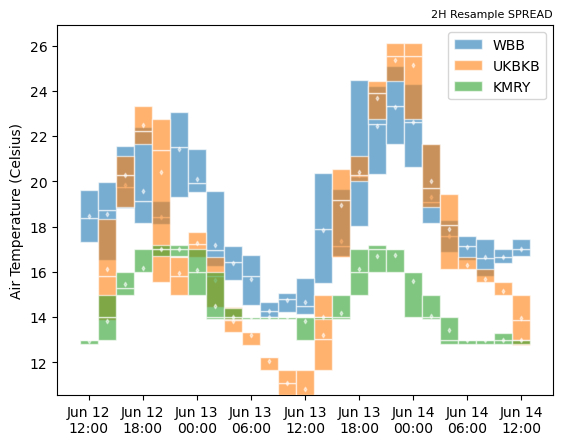

In [39]:
plot_spread_bars(Z["WBB"], "2H", "resample")
plot_spread_bars(Z["UKBKB"], "2H", "resample")
plot_spread_bars(Z["KMRY"], "2H", "resample")
plt.gca().legend()

air_temp_set_1


<Axes: ylabel='Air Temperature (Celsius)'>

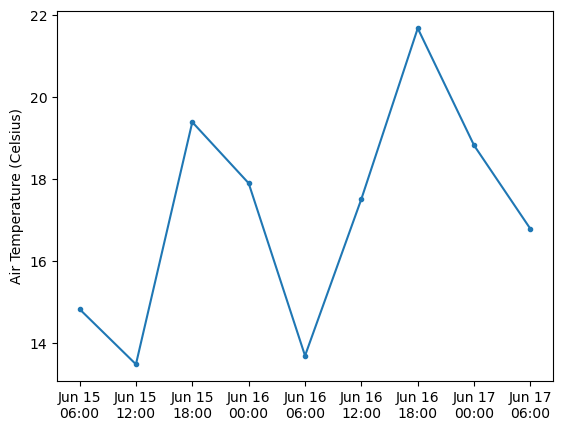

In [21]:
smooth.smooth_dataframe(df).pipe(plot_standard)


In [17]:
for column in sorted(df.columns):
    variable = re.sub(r"_set_\d+d?", "", column)

air_temp_set_1
air_temp_set_1
air_temp_set_1
air_temp_set_1
air_temp_set_2


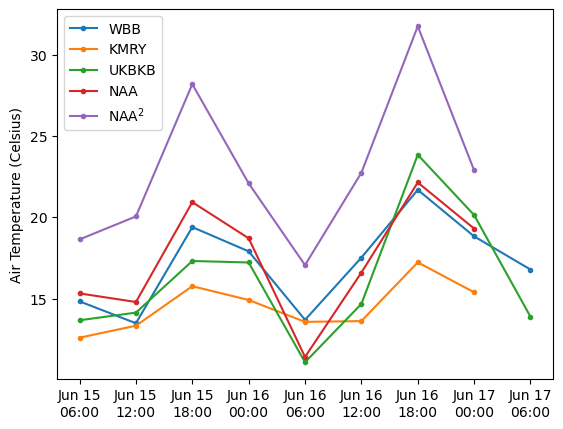

In [23]:
for station, df in Z.items():
    smooth.smooth_dataframe(df).pipe(plot_standard, False)
plt.gca().legend()
plt.title()

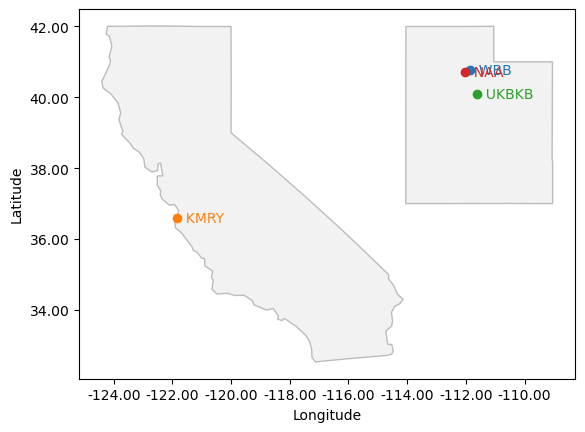

In [41]:
states = {df.attrs.get("STATE") for _, df in Z.items()}
for state in states:
    draw_state_polygon(
        state,
        facecolor=".9",
        edgecolor=".5",
        alpha=0.5,
        zorder=2,
    )

for station, df in Z.items():
    plot_station_on_map(df)

plt.gca().grid(color="w", linewidth=2, alpha=0.8, zorder=1)

# ----------
# Map bounds
# Use zoomed-in map boundary if max distance between stations is large.
latitudes = [i.attrs["latitude"] for i in Z.values()]
longitudes = [i.attrs["longitude"] for i in Z.values()]
points = zip(latitudes, longitudes)
pairs = list(itertools.product(points, repeat=2))

threshold = 0.5
pad = 0.08
max_distance = max(list(map(lambda x: calculate_distance(*x[0], *x[1]), pairs)))
xlim = (min(longitudes) - pad / 2, max(longitudes) + pad / 2)
ylim = (min(latitudes) - pad, max(latitudes) + pad)

if max_distance < threshold:
    plt.gca().set_xlim(*xlim)
    plt.gca().set_ylim(*ylim)

In [3]:
precip_vars = [
    "precip_accum",
    "precip_accum_one_minute",
    "precip_accum_ten_minute",
    "precip_accum_fifteen_minute",
    "precip_accum_30_minute",
    "precip_accum_one_hour",
    "precip_accum_three_hour",
    "precip_storm",
    "precip_accum_six_hour",
    "precip_accum_24_hour",
    "precip_smoothed",
    "precip_manual",
    "precip_accum_manual",
    "precip_accum_5_minute_manual",
    "precip_accum_10_minute_manual",
    "precip_accum_15_minute_manual",
    "precip_accum_3_hour_manual",
    "precip_accum_6_hour_manual",
    "precip_accum_24_hour_manual",
    "precip_accum_12_hour",
    "precip_accum_five_minute",
    "precip_accum_since_00utc",
    "precip_accum_since_7_local",
    "precip_accum_since_local_midnight",
    "precip_interval",
]
df = stations_timeseries(
    stid="WBB",
    recent="300H",
    vars=",".join(precip_vars),
    precip=1,
    rename_set_1=False,
)

plot_standard_precip(df)
df

Checking for data recent=18000 minutes.

 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=WBB&recent=18000&vars=precip_accum,precip_accum_one_minute,precip_accum_ten_minute,precip_accum_fifteen_minute,precip_accum_30_minute,precip_accum_one_hour,precip_accum_three_hour,precip_storm,precip_accum_six_hour,precip_accum_24_hour,precip_smoothed,precip_manual,precip_accum_manual,precip_accum_5_minute_manual,precip_accum_10_minute_manual,precip_accum_15_minute_manual,precip_accum_3_hour_manual,precip_accum_6_hour_manual,precip_accum_24_hour_manual,precip_accum_12_hour,precip_accum_five_minute,precip_accum_since_00utc,precip_accum_since_7_local,precip_accum_since_local_midnight,precip_interval&precip=1&token=🙈HIDDEN



NameError: name 'plot_standard_precip' is not defined

In [7]:
if "precip_intervals_set_1d" in df.columns:
    df = df.drop("precip_intervals_set_1d", axis=1)

In [9]:
if "precip_intervals_set_1d" in df.columns:
    df = df.drop("precip_intervals_set_1d", axis=1)
df


,precip_accumulated_set_1d
date_time,
2023-06-04 22:08:00+00:00,0.0
2023-06-04 22:09:00+00:00,0.0
2023-06-04 22:10:00+00:00,0.0
2023-06-04 22:11:00+00:00,0.0
2023-06-04 22:12:00+00:00,0.0
...,...
2023-06-17 09:57:00+00:00,12.7
2023-06-17 09:58:00+00:00,12.7
2023-06-17 09:59:00+00:00,12.7
